In [3]:
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


In [4]:
from sklearn.model_selection import train_test_split
import re 
import tensorflow as tf
import numpy as np 

raw = []
raw_corpus = [] 
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)
        

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()  # 소문자, 양쪽공백 제거
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)  # 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)  # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  # 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환
    sentence = sentence.strip()  # 양쪽 공백 제거
    sentence = '<start> ' + sentence + ' <end>'
    return sentence

corpus = []  # 형태 : ['<start> i m begging of you please don t take my man <end>', ...] length - 175986
for sentence in raw_corpus:
    if len(sentence) == 0: continue
    tmp = preprocess_sentence(sentence)
    if len(tmp.split()) > 20: continue
    corpus.append(tmp)

    
def tokenize(corpus):
    # num_words:전체 단어의 개수, filters:별도로 전처리 로직을 추가, oov_token: out-of-vocabulary 사전에 없었던 단어는 어떤 토큰으로 대체할지
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=12000, filters=' ', oov_token="<unk>")
    tokenizer.fit_on_texts(corpus)  # corpus로부터 Tokenizer가 사전을 자동구축
    # tokenizer를 활용하여 모델에 입력할 데이터셋 구축(Tensor로 변환)
    tensor = tokenizer.texts_to_sequences(corpus)
    total_data_text = list(tensor)
    num_tokens = [len(tokens) for tokens in total_data_text]
    max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    # 입력 데이터 시퀀스 길이 맞춰주기 - padding
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=maxlen)

    return tensor, tokenizer



tensor, tokenizer = tokenize(corpus)

for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if len(sentence) > 15: continue
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.
        
print(sentence[:10])

src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성. 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높다.
tgt_input = tensor[:, 1:]  # tensor에서 <start>를 잘라내서 타겟 문장을 생성 -> 문장 길이는 14가 됨

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=48)
print("Source Train:", enc_train.shape)  # (124960, 14)  # 현재 (124981, 14)
print("Target Train:", dec_train.shape)  # (124960, 14)

You know, 
Source Train: (135828, 16)
Target Train: (135828, 16)


In [5]:
#Loss
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding,LSTM, GRU,SimpleRNN,  Dense

def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()
    

Epoch 1/3
4528/4528 [==============================] - 2950s 608ms/step - loss: 2.5952 - val_loss: 2.3019
Epoch 2/3
4528/4528 [==============================] - 2756s 609ms/step - loss: 2.0063 - val_loss: 2.1147
Epoch 3/3
4528/4528 [==============================] - 2758s 609ms/step - loss: 1.6376 - val_loss: 2.0707


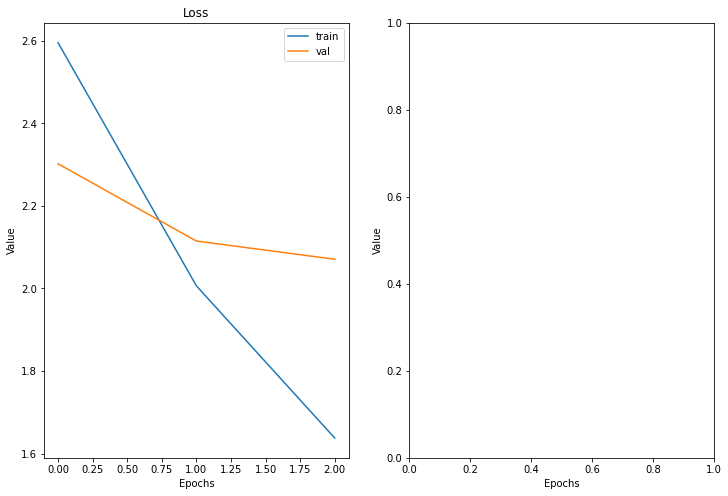

In [6]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        self.rnn_0 = LSTM(hidden_size,return_sequences = True)
        self.embedding = Embedding(vocab_size, embedding_size)
        self.rnn_1 = GRU(hidden_size, return_sequences=True)
        #self.rnn_2 = GRU(hidden_size,return_sequences = True)
        #self.rnn_3 = GRU(hidden_size, return_sequences=True)
        #self.rnn_4 = GRU(hidden_size, return_sequences=True)
        self.rnn_3 = GRU(hidden_size,return_sequences = True)
        self.linear = Dense(vocab_size)
        
    def call(self, x):
       
        out = self.embedding(x)
        out = self.rnn_0(out)
        out = self.rnn_1(out)
        #out = self.rnn_2(out)
        #out = self.rnn_3(out)
        #out = self.rnn_4(out)
        out = self.linear(out)
        
        return out

history = []
epochs = 3

optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

embedding_size = 5000
hidden_size = 5000


model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
model.compile(loss=loss, optimizer=optimizer)

history = model.fit(enc_train, 
          dec_train, 
          epochs=epochs,
          batch_size=30,
          validation_data=(enc_val, dec_val),
          verbose=1)
    


loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

plot_curve(history.epoch, history.history, ['loss', 'val_loss'])

def generate_text(model, tokenizer, init_sentence="<start>", max_len=40):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <END>를 예측하지 않았거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated 

In [7]:

def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 우리 모델이 <END>를 예측하지 않았거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.


generate_text(model, tokenizer, init_sentence="<start> I ", max_len=20)

'<start> i m a bad bitch , no , no , no , no <end> '

In [8]:
generate_text(model, tokenizer, init_sentence="<start> object ", max_len=300)

'<start> object to the <unk> <end> '

In [9]:
generate_text(model, tokenizer, init_sentence="<start> deny that ", max_len=300)

'<start> deny that i m a boss <end> '

In [10]:
generate_text(model, tokenizer, init_sentence="<start> so that ", max_len=300)

'<start> so that s why i m like like a <unk> <end> '

In [11]:
generate_text(model, tokenizer, init_sentence="<start> I love ", max_len=300)

'<start> i love you so , so , i do <end> '

In [12]:
generate_text(model, tokenizer, init_sentence="<start> I love ", max_len=300)

'<start> i love you so , so , i do <end> '

In [13]:
generate_text(model, tokenizer, init_sentence="<start> I think that ", max_len=300)

'<start> i think that you re going to have a good time <end> '

In [14]:
generate_text(model, tokenizer, init_sentence="<start> good ", max_len=300)

'<start> good morning <end> '

In [15]:
generate_text(model, tokenizer, init_sentence="<start> so bad ", max_len=300)

'<start> so bad , coulda thought i owed a owed <end> '

In [16]:
generate_text(model, tokenizer, init_sentence="<start> get boy ", max_len=300)

'<start> get boy , get out the way <end> '

In [17]:
generate_text(model, tokenizer, init_sentence="<start> gotta ", max_len=300)

'<start> gotta get me some . . . all day all day <end> '

In [18]:
generate_text(model, tokenizer, init_sentence="<start> I'm a ", max_len=300)

'<start> <unk> a <unk> <end> '

In [19]:
generate_text(model, tokenizer, init_sentence="<start> hey ", max_len=300)

'<start> hey , hey , hey , hey , hey , hey , hey <end> '

In [20]:
generate_text(model, tokenizer, init_sentence="<start> why ", max_len=300)

'<start> why do i feel like the only one ? <end> '

In [21]:
generate_text(model, tokenizer, init_sentence="<start> out of  ", max_len=300)

'<start> out of control , <end> '

In [22]:
generate_text(model, tokenizer, init_sentence="<start> of ", max_len=300)

'<start> of <unk> <unk> <end> '

In [23]:
generate_text(model, tokenizer, init_sentence="<start> of the ", max_len=300)

'<start> of the <unk> <unk> <end> '

In [24]:
generate_text(model, tokenizer, init_sentence="<start> she ", max_len=300)

'<start> she s got a look at me <end> '

In [25]:
generate_text(model, tokenizer, init_sentence="<start> she likes ", max_len=300)

'<start> she likes the way you did <end> '

In [26]:
generate_text(model, tokenizer, init_sentence="<start> he likes ", max_len=300)

'<start> he likes to shoot his gun <end> '

In [27]:
generate_text(model, tokenizer, init_sentence="<start> He likes ", max_len=300)

'<start> he likes to shoot his gun <end> '

In [28]:
generate_text(model, tokenizer, init_sentence="<start> my little ", max_len=20)

'<start> my little sister , give me your eye <end> '